In [21]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'f_1239_0_0'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=10000, latent_dim=120, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [22]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [23]:
# Load ADNI model

import pickle

adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weightsBalanced3.pkl', 'rb'))
# adni = {'coef': None, 'intercept': 0}
# adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corrBalanced.pkl', 'rb'))

list(adni.keys())

['intercept', 'coef']

In [24]:
# Load sub FCS

import numpy as np

inter_subs_fc = pickle.load(open('/home/anton/Documents/Yale/UKB/inter_subs_fc.pkl', 'rb'))
fcs = []
count = 0

for sub in inter_subs_fc:
    p = np.load(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/conn/{sub}_task-20227-2_fc.npy')
    fcs.append(p)
    count += 1
    if count == 700:
        break

fcs = np.stack(fcs)
print(len(fcs))

700


In [25]:
dct['demos'][4][:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [26]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    # synth = vae.transform(fcs, dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-74.63713811092731
1.4423634339403157


In [31]:
vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    # ndemo[4] = 0*np.ones(len(ndemo[1]))
    ndemo[4] -= 2
    
    nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    # nsynth = vae.transform(fcs, ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20

    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-78.56159491004468
1.9333783118531649


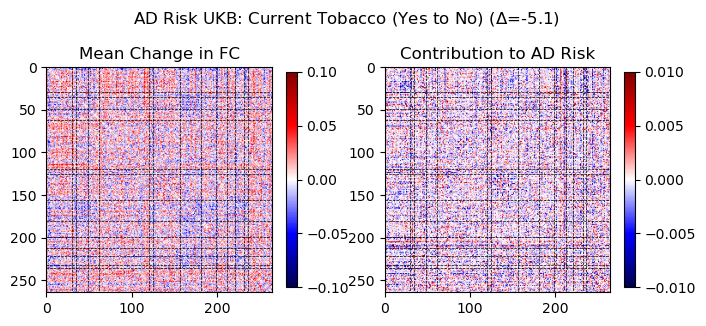

In [32]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,3.5))

subject = 'UKB: Current Tobacco (Yes to No)'
delta = '-5.1'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')
scale = 0.1

norm1 = TwoSlopeNorm(vmax=scale, vmin=-scale, vcenter=0)
norm2 = TwoSlopeNorm(vmax=scale/10, vmin=-scale/10, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
fig.savefig(f'/home/anton/Documents/Yale/UKB/Figures/FCChanges2/{tit}.pdf')

In [33]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit, delta)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)

for i in range(len(divis)-1):
    for j in range(i,len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        val = np.mean(W[r1a:r1b,r2a:r2b])
        vals.append(val)
        val = np.sum(W[r1a:r1b,r2a:r2b])
        sums.append(val)
        labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

UKB:_Current_Tobacco_(Yes_to_No) -5.1
Individual ROIs
31069 178 187 FRNT SAL -0.021517412055001506
1241 4 200 SMTH SUB -0.021247646336617302
25941 131 135 VIS VIS 0.021094700710230042
32577 198 205 SAL SUB 0.020785039478059177
33281 209 260 SUB UNK -0.020054138200912782
34526 244 245 UNK UNK 0.019660584914031973
6037 24 26 SMTH SMTH -0.019497098140106767
33280 209 259 SUB UNK -0.01916526952200029
Networks Mean
-0.0010066827717939394 MEM-DRSL
0.0009786185694954756 SMTM-SAL
-0.0009616141219071987 SMTH-MEM
-0.0008999201179083822 SMTH-CBL
-0.0007993520555878231 SMTM-CBL
-0.0007196966421385015 SMTM-SMTM
-0.0007155419617463707 AUD-VTRL
-0.0007093522851622504 MEM-FRNT
Networks Sum
-0.5195791325112107 SMTH-SMTH
-0.4772747746968208 VIS-VIS
-0.40305486642069643 DMN-DMN
-0.32095906881821523 SMTH-UNK
0.29209106400460705 DMN-VIS
-0.26139731622262047 DMN-DRSL
-0.23476104043435989 SMTH-FRNT
-0.22943249320681036 DMN-FRNT
